In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'logit'

In [4]:
# Parameters
model_size = "7b"
target_lang = "ru"
input_lang = "zh"
type = "tuned"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-7b-hf None


params.pt:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

(…)ens/meta-llama/Llama-2-7b-hf/config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_target_input.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for ru 15 of 115 are single tokens
final length of df_en_ru_zh: 115


In [8]:
df_en_target_input

,lang_ru,en,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error,lang_zh,zh,blank_prompt_original_zh,blank_prompt_translation_zh,blank_prompt_translation_masked_zh
0,ru,book,книга,"A ""book"" is used to read stories. Answer: ""book"".","""Книга"" используется для чтения историй. Ответ...","""___"" используется для чтения историй. Ответ: ...",no error,zh,书,"A ""book"" is used to read stories. Answer: ""book"".","""书""用来阅读故事。答案：""书""。","""_""用来阅读故事。答案：""书""。"
1,ru,cloud,облако,"A ""cloud"" is a visible mass of condensed water...",Облако - это видимая масса конденсированного в...,"""___"" - это видимая масса конденсированного во...",no error,zh,云,"A ""cloud"" is a visible mass of condensed water...","""云""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。","""_""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。"
2,ru,bag,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error,zh,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
3,ru,mouth,рот,"A ""mouth"" is used to eat food and speak. Answe...",Рот используется для приема пищи и речи. Ответ...,"""___"" используется для приема пищи и речи. Отв...",no error,zh,口,"A ""mouth"" is used to eat food and speak. Answe...","""口""用来吃食物和说话。答案：""口""。","""_""用来吃食物和说话。答案：""口""。"
4,ru,soil,почва,"""A ""soil"" is used for planting trees and crops...","""Почва"" используется для посадки деревьев и вы...","""___"" используется для посадки деревьев и выра...",no error,zh,土,"""A ""soil"" is used for planting trees and crops...","""土""用于种植树木和作物。答案：""土""。","""_""用于种植树木和作物。答案：""土""。"
...,...,...,...,...,...,...,...,...,...,...,...,...
110,ru,hundred,сотня,"A ""hundred"" is a numerical value equal to 10 t...","Сотня - это числовое значение, равное 10 десят...","""___"" - это числовое значение, равное 10 десят...",no error,zh,百,"A ""hundred"" is a numerical value equal to 10 t...","""百""是数值，等于10个十。答案：""百""。","""_""是数值，等于10个十。答案：""百""。"
111,ru,office,офис,"An ""office"" is a place where people usually do...","Офис - это место, где люди обычно выполняют св...","""___"" - это место, где люди обычно выполняют с...",no error,zh,局,"An ""office"" is a place where people usually do...","""局""是人们通常进行工作的地方。答案：""局""。","""_""是人们通常进行工作的地方。答案：""局""。"
112,ru,sound,звук,"A ""sound"" is something we hear. Answer: ""sound"".","Звук - это то, что мы слышим. Ответ: ""звук"".","""___"" - это то, что мы слышим. Ответ: ""звук"".",no error,zh,音,"A ""sound"" is something we hear. Answer: ""sound"".","""音""是我们听到的东西。答案：""音""。","""_""是我们听到的东西。答案：""音""。"
113,ru,power,власть,"""A ""power"" is used to control or influence peo...","""Власть"" используется для контроля или влияния...","""___"" используется для контроля или влияния на...",no error,zh,力,"""A ""power"" is used to control or influence peo...","""力""用来控制或影响人或物。答案：""力""。","""_""用来控制或影响人或物。答案：""力""。"


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/115 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                             | 1/115 [00:00<00:22,  5.04it/s]

  2%|███▌                                                                                                                                                                                                           | 2/115 [00:00<00:25,  4.40it/s]

  3%|█████▍                                                                                                                                                                                                         | 3/115 [00:00<00:23,  4.84it/s]

  3%|███████▏                                                                                                                                                                                                       | 4/115 [00:00<00:22,  5.01it/s]

  4%|█████████                                                                                                                                                                                                      | 5/115 [00:01<00:25,  4.39it/s]

  5%|██████████▊                                                                                                                                                                                                    | 6/115 [00:01<00:33,  3.30it/s]

  6%|████████████▌                                                                                                                                                                                                  | 7/115 [00:01<00:31,  3.38it/s]

  7%|██████████████▍                                                                                                                                                                                                | 8/115 [00:02<00:31,  3.36it/s]

  8%|████████████████▏                                                                                                                                                                                              | 9/115 [00:02<00:30,  3.50it/s]

  9%|█████████████████▉                                                                                                                                                                                            | 10/115 [00:02<00:29,  3.57it/s]

 10%|███████████████████▋                                                                                                                                                                                          | 11/115 [00:02<00:25,  4.03it/s]

 10%|█████████████████████▍                                                                                                                                                                                        | 12/115 [00:03<00:27,  3.74it/s]

 11%|███████████████████████▎                                                                                                                                                                                      | 13/115 [00:03<00:25,  4.01it/s]

 12%|█████████████████████████                                                                                                                                                                                     | 14/115 [00:03<00:23,  4.29it/s]

 13%|██████████████████████████▊                                                                                                                                                                                   | 15/115 [00:03<00:22,  4.51it/s]

 14%|████████████████████████████▋                                                                                                                                                                                 | 16/115 [00:03<00:21,  4.55it/s]

 15%|██████████████████████████████▍                                                                                                                                                                               | 17/115 [00:04<00:21,  4.55it/s]

 16%|████████████████████████████████▏                                                                                                                                                                             | 18/115 [00:04<00:20,  4.74it/s]

 17%|██████████████████████████████████                                                                                                                                                                            | 19/115 [00:04<00:20,  4.77it/s]

 17%|███████████████████████████████████▊                                                                                                                                                                          | 20/115 [00:04<00:20,  4.71it/s]

 18%|█████████████████████████████████████▌                                                                                                                                                                        | 21/115 [00:04<00:19,  4.93it/s]

 19%|███████████████████████████████████████▍                                                                                                                                                                      | 22/115 [00:05<00:19,  4.88it/s]

 20%|█████████████████████████████████████████▏                                                                                                                                                                    | 23/115 [00:05<00:18,  4.86it/s]

 21%|██████████████████████████████████████████▉                                                                                                                                                                   | 24/115 [00:05<00:18,  4.83it/s]

 22%|████████████████████████████████████████████▊                                                                                                                                                                 | 25/115 [00:05<00:17,  5.05it/s]

 23%|██████████████████████████████████████████████▌                                                                                                                                                               | 26/115 [00:05<00:17,  5.05it/s]

 23%|████████████████████████████████████████████████▎                                                                                                                                                             | 27/115 [00:06<00:19,  4.53it/s]

 24%|██████████████████████████████████████████████████▏                                                                                                                                                           | 28/115 [00:06<00:19,  4.53it/s]

 25%|███████████████████████████████████████████████████▉                                                                                                                                                          | 29/115 [00:06<00:18,  4.56it/s]

 26%|█████████████████████████████████████████████████████▋                                                                                                                                                        | 30/115 [00:06<00:20,  4.17it/s]

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                      | 31/115 [00:07<00:18,  4.49it/s]

 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                    | 32/115 [00:07<00:20,  4.12it/s]

 29%|███████████████████████████████████████████████████████████                                                                                                                                                   | 33/115 [00:07<00:18,  4.41it/s]

 30%|████████████████████████████████████████████████████████████▉                                                                                                                                                 | 34/115 [00:07<00:17,  4.52it/s]

 30%|██████████████████████████████████████████████████████████████▋                                                                                                                                               | 35/115 [00:08<00:17,  4.60it/s]

 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                             | 36/115 [00:08<00:16,  4.74it/s]

 32%|██████████████████████████████████████████████████████████████████▎                                                                                                                                           | 37/115 [00:08<00:16,  4.59it/s]

 33%|████████████████████████████████████████████████████████████████████                                                                                                                                          | 38/115 [00:08<00:15,  5.03it/s]

 34%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 39/115 [00:08<00:15,  5.01it/s]

 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 40/115 [00:09<00:15,  4.90it/s]

 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 41/115 [00:09<00:14,  5.02it/s]

 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 42/115 [00:09<00:13,  5.31it/s]

 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 43/115 [00:09<00:14,  5.01it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 44/115 [00:09<00:13,  5.42it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 45/115 [00:09<00:13,  5.33it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 46/115 [00:10<00:13,  5.04it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 47/115 [00:10<00:13,  5.21it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 48/115 [00:10<00:12,  5.30it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 49/115 [00:10<00:12,  5.25it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 50/115 [00:10<00:13,  4.89it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 51/115 [00:11<00:13,  4.86it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 52/115 [00:11<00:12,  4.90it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 53/115 [00:11<00:12,  4.78it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 54/115 [00:11<00:13,  4.65it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 55/115 [00:12<00:13,  4.35it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 56/115 [00:12<00:13,  4.28it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 57/115 [00:12<00:13,  4.28it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/115 [00:12<00:13,  4.35it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 59/115 [00:13<00:12,  4.37it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 60/115 [00:13<00:12,  4.45it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 61/115 [00:13<00:11,  4.54it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 62/115 [00:13<00:11,  4.55it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 63/115 [00:13<00:12,  4.29it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 64/115 [00:14<00:11,  4.36it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 65/115 [00:14<00:12,  4.03it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 66/115 [00:14<00:12,  3.78it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 67/115 [00:15<00:13,  3.47it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 68/115 [00:15<00:13,  3.60it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 69/115 [00:15<00:13,  3.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 70/115 [00:15<00:12,  3.75it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 71/115 [00:16<00:10,  4.05it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 72/115 [00:16<00:09,  4.33it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 73/115 [00:16<00:09,  4.43it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 74/115 [00:16<00:09,  4.35it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 75/115 [00:17<00:10,  3.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 76/115 [00:17<00:09,  3.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 77/115 [00:17<00:09,  3.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 78/115 [00:17<00:08,  4.22it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 79/115 [00:17<00:08,  4.31it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 80/115 [00:18<00:08,  4.23it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 81/115 [00:18<00:08,  4.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 82/115 [00:18<00:07,  4.16it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 83/115 [00:18<00:07,  4.09it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 84/115 [00:19<00:07,  4.09it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 85/115 [00:19<00:08,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 86/115 [00:19<00:07,  4.01it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 87/115 [00:19<00:06,  4.30it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 88/115 [00:20<00:06,  4.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 89/115 [00:20<00:06,  3.76it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 90/115 [00:20<00:06,  3.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 91/115 [00:21<00:06,  3.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 92/115 [00:21<00:06,  3.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 93/115 [00:21<00:05,  4.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 94/115 [00:21<00:05,  3.70it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 95/115 [00:22<00:05,  3.96it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 96/115 [00:22<00:04,  3.94it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 97/115 [00:22<00:04,  3.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 98/115 [00:22<00:04,  3.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 99/115 [00:23<00:04,  3.92it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 100/115 [00:23<00:03,  3.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 101/115 [00:23<00:03,  3.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 102/115 [00:23<00:03,  4.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 103/115 [00:24<00:02,  4.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 104/115 [00:24<00:02,  4.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 105/115 [00:24<00:02,  3.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 106/115 [00:24<00:02,  4.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 107/115 [00:25<00:01,  4.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 108/115 [00:25<00:01,  4.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 109/115 [00:25<00:01,  4.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 110/115 [00:25<00:01,  3.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 111/115 [00:26<00:01,  3.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 112/115 [00:26<00:00,  4.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 113/115 [00:26<00:00,  4.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 114/115 [00:26<00:00,  4.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:26<00:00,  4.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:26<00:00,  4.26it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"中文: ""群"" - Русский: ""группа""\n中文: ""山"" - Русский...","[1186, 29951, 13024, 211]",книга,"[29890, 833, 3143, 2909, 1045, 289]",book,书
1,"中文: ""月"" - Русский: ""луна""\n中文: ""回"" - Русский: ...","[614, 1604, 29904, 5055, 4389, 211]",облако,"[1067, 23642, 9274, 274, 695, 29883, 15126, 17...",cloud,云
2,"中文: ""歌"" - Русский: ""песня""\n中文: ""月"" - Русский:...","[3404, 531, 2937, 29935, 212]",сумка,"[29890, 2291, 19548, 9922, 23156, 289]",bag,包
3,"中文: ""位"" - Русский: ""позиция""\n中文: ""种"" - Русски...","[576, 8201, 1561, 29927, 212]",рот,"[2730, 21026, 29442, 29885, 286, 4346, 13394]",mouth,口
4,"中文: ""项"" - Русский: ""предмет""\n中文: ""种"" - Русски...","[18752, 469, 1268, 733, 29964, 211]",почва,"[578, 269, 22473, 29879, 577]",soil,土
...,...,...,...,...,...,...
110,"中文: ""城"" - Русский: ""город""\n中文: ""足"" - Русский:...","[1778, 531, 2223, 29935, 23966, 212]",сотня,"[6905, 6893, 9074, 29882, 298, 22888]",hundred,百
111,"中文: ""会"" - Русский: ""собрание""\n中文: ""火"" - Русск...","[614, 29904, 211]",офис,"[20205, 288, 310, 29877, 1283, 974, 2696, 3344...",office,局
112,"中文: ""源"" - Русский: ""источник""\n中文: ""话"" - Русск...","[27643, 754, 29972, 29351, 211]",звук,"[578, 269, 3669, 6047, 29802, 29879, 577]",sound,音
113,"中文: ""条"" - Русский: ""полоса""\n中文: ""代"" - Русский...","[29942, 8672, 490, 211]",власть,"[4764, 772, 29886, 12248, 282, 13519, 1129, 3081]",power,力


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.10it/s]

2it [00:01,  1.91it/s]

3it [00:01,  2.77it/s]

4it [00:01,  3.39it/s]

5it [00:01,  3.88it/s]

6it [00:01,  3.87it/s]

7it [00:02,  4.04it/s]

8it [00:02,  4.42it/s]

9it [00:02,  4.65it/s]

10it [00:02,  4.76it/s]

11it [00:02,  4.64it/s]

12it [00:03,  4.52it/s]

13it [00:03,  4.71it/s]

14it [00:03,  4.63it/s]

15it [00:03,  4.72it/s]

16it [00:04,  4.66it/s]

17it [00:04,  4.76it/s]

18it [00:04,  4.84it/s]

19it [00:04,  5.04it/s]

20it [00:04,  5.06it/s]

21it [00:05,  4.87it/s]

22it [00:05,  4.97it/s]

23it [00:05,  5.09it/s]

24it [00:05,  5.15it/s]

25it [00:05,  5.04it/s]

26it [00:06,  4.60it/s]

27it [00:06,  4.90it/s]

28it [00:06,  5.06it/s]

29it [00:06,  5.35it/s]

30it [00:06,  5.26it/s]

31it [00:06,  5.59it/s]

32it [00:07,  5.86it/s]

33it [00:07,  5.46it/s]

34it [00:07,  4.94it/s]

35it [00:07,  4.91it/s]

36it [00:08,  4.77it/s]

37it [00:08,  4.85it/s]

38it [00:08,  4.74it/s]

39it [00:08,  4.78it/s]

40it [00:08,  4.98it/s]

41it [00:09,  4.98it/s]

42it [00:09,  5.05it/s]

43it [00:09,  5.30it/s]

44it [00:09,  5.42it/s]

45it [00:09,  5.48it/s]

46it [00:09,  5.51it/s]

47it [00:10,  5.45it/s]

48it [00:10,  5.51it/s]

49it [00:10,  5.58it/s]

50it [00:10,  5.44it/s]

51it [00:10,  4.97it/s]

52it [00:11,  5.06it/s]

53it [00:11,  4.65it/s]

54it [00:11,  4.88it/s]

55it [00:11,  5.04it/s]

56it [00:11,  5.22it/s]

57it [00:12,  5.33it/s]

58it [00:12,  5.15it/s]

59it [00:12,  5.40it/s]

60it [00:12,  5.12it/s]

61it [00:12,  4.92it/s]

62it [00:13,  4.92it/s]

63it [00:13,  4.84it/s]

64it [00:13,  4.68it/s]

65it [00:13,  4.84it/s]

66it [00:13,  4.69it/s]

67it [00:14,  4.95it/s]

68it [00:14,  5.10it/s]

69it [00:14,  5.34it/s]

70it [00:14,  5.28it/s]

71it [00:14,  5.07it/s]

72it [00:15,  5.02it/s]

73it [00:15,  4.98it/s]

74it [00:15,  5.19it/s]

75it [00:15,  5.04it/s]

76it [00:15,  4.86it/s]

77it [00:16,  4.77it/s]

78it [00:16,  4.82it/s]

79it [00:16,  5.04it/s]

80it [00:16,  4.93it/s]

81it [00:16,  4.72it/s]

82it [00:17,  4.83it/s]

83it [00:17,  4.74it/s]

84it [00:17,  4.51it/s]

85it [00:17,  4.38it/s]

86it [00:18,  4.45it/s]

87it [00:18,  4.55it/s]

88it [00:18,  4.86it/s]

89it [00:18,  4.93it/s]

90it [00:18,  5.09it/s]

91it [00:19,  4.97it/s]

92it [00:19,  4.84it/s]

93it [00:19,  4.81it/s]

94it [00:19,  4.95it/s]

95it [00:19,  5.06it/s]

96it [00:20,  4.88it/s]

97it [00:20,  4.69it/s]

98it [00:20,  4.75it/s]

99it [00:20,  5.02it/s]

100it [00:20,  5.38it/s]

101it [00:20,  5.63it/s]

102it [00:21,  5.76it/s]

103it [00:21,  5.46it/s]

104it [00:21,  5.08it/s]

105it [00:21,  5.10it/s]

106it [00:21,  5.16it/s]

107it [00:22,  5.18it/s]

108it [00:22,  4.95it/s]

109it [00:22,  4.73it/s]

110it [00:22,  4.98it/s]

111it [00:22,  5.12it/s]

112it [00:23,  5.37it/s]

113it [00:23,  5.53it/s]

114it [00:23,  5.74it/s]

115it [00:23,  5.74it/s]

115it [00:23,  4.87it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


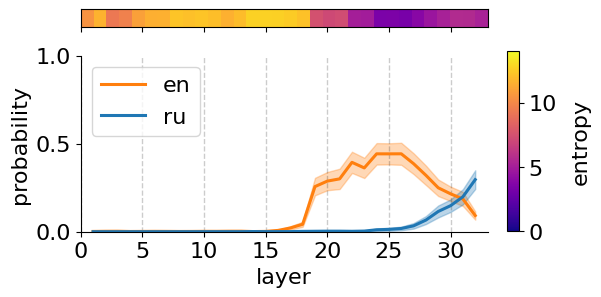

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

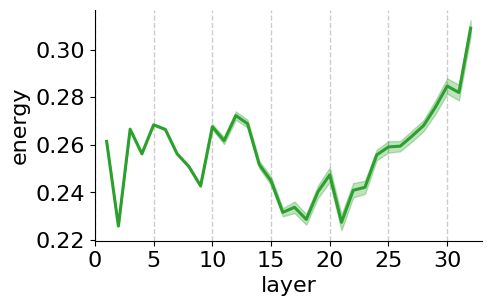

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')